# Gridworld
## Introduction
In this notebook, we would be implementing the Gridworld as described in the book, Reinforcement Learning: An Introduction[Sutton, R. S., Bach, F., &amp; Barto, A. G. (2018). Reinforcement learning: An introduction. MIT Press Ltd. ]
### Gridworld
A gridworld is a 2D rectangular grid of size (Ny, Nx) with an agent starting off at one grid square and trying to move to another grid square located elsewhere. Each cell in the grid is considered a state and a grid can contain starting states, terminal states, and non-terminal states.
### Our Gridworld
In this notebook, we would be referencing the gridworld example in the book, under **Example 4.1**.

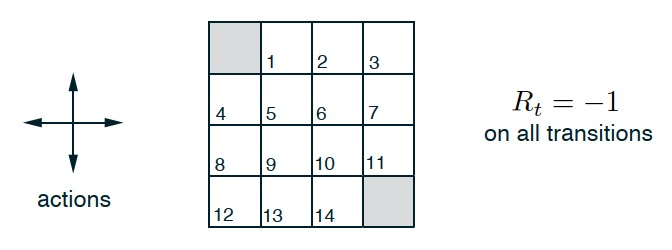

In this example, we see that there are 2 terminal states (shaded black), 14 starting states labeled 1-14, and no starting states. It is also given that in each state, an agent can take 4 actions, up, down, left, and right, with a reward of -1 on each transition. In other words,

$$
\text{State Space} \leftarrow S={1,2,...,14} \\
\text{Action Space} \leftarrow A={up, down, left, right}\\
{R_t=-1}_\text{On all transitions}
$$

Lastly, it is also given that the agent follows an equiprobable random policy, meaning that all actions are equally likely to be taken in each state.

$$
\pi(a \mid s) = 0.35
$$

## Agent-Environment Interface
Recall that in Reinforcement Learning, the problem to resolve is described as a Markov Decision Process(MDP). The learning and decision maker is called the *agent*, where the thing it interacts with, comprising everything outside the agent, is called the *environment*. These components interact continually, with the agent selecting actions and the environment responding to these actions and presenting new situations to the agent. The environment also gives rewards, special numerical values that the agent seeks to maximize over time through its choice of actions.

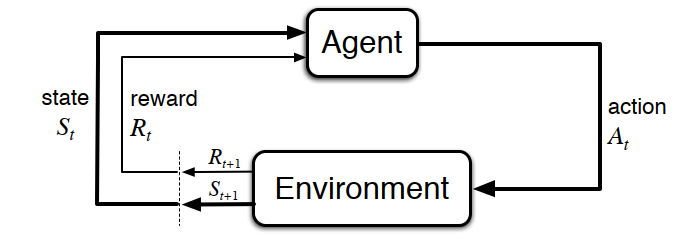

## Environment
As mentioned, the environment is the thing that agents interact with, presenting new situations and giving rewards to the agent after agents select an action. Let's begin developing our environment.

*Note: From here on, we would be using [this Medium article](https://medium.com/analytics-vidhya/a-simple-reinforcement-learning-environment-from-scratch-72c37bb44843) and the [OpenAI Gym API reference](https://www.gymlibrary.dev/api/core/#gym-env) as references.*

### RL Environment Fundamentals
The following are necessities for an RL Environment:
1. State/Observation set of the environment
2. Reward/Penalty from environment to agent
3. Action set for agent, within boundaries of the environment

### Environment Class
To encompass the fundamentals above, these are the methods that we would require to build our environment:
#### step()
Run one timestep of the environment's dynamics.

<u>Inputs</u><br>
*action* - An action provided by the agent.

<u>Outputs</u><br>
*observation* - An element of the environment's *observation_space*.<br>
*reward* - Amount of reward returned as a result of taking the action.<br>
*terminated* - Whether a *terminal state* is reached. Further *step()* calls could return undefined results.<br>
*truncated* - Whether a truncation condition outside the scope of the MDP is satisfied. Usually a timelimit, but could also mean agent going out of bounds.<br>
*info* - Contains auxiliary diagnostic information. i.e. Metrics describing agent's performance state, variables that are hidden from observations, etc.<br>
#### reset()
Resets the environment to an initial state and returns the initial observation. Typically called after an entire episode.

<u>Outputs</u><br>
*observation* - Observation of the initial state. An element of the *observation_space*.
*info*  Contains information complementing *observation*. Same as *info* in *step()*.

*Note: In OpenAI Gym's implementation, a class 'space' is used to define observation_space and action_space. Spaces are crucially used in Gym to define the format of valid actions and observations and serve various purposes:*
- They clearly define how to interact with environments, i.e. they specify what actions need to look like and what observations will look like
- They allow us to work with highly structured data (e.g. in the form of elements of Dict spaces) and painlessly transform them into flat arrays that can be used in learning code
- They provide a method to sample random elements. This is especially useful for exploration and debugging.

*In this notebook, we will NOT be implementing this class and will treat all actions and observation as discrete values.*

## Environment - Implementation
Let's implement our environment.

In [1]:
import numpy as np

class gridworld_env:
    def __init__(self, size):
        self.size = size
        self.state = 1
        self.action_space = [0, 1, 2, 3] # up, down, left, right
        self.observation_space = np.array(range(0, size*size)) # 1-D grid
        
        # initialize dynamics of environment
        self.P = np.full((len(self.observation_space), len(self.action_space)), (0.0, 0, 0.0, False), dtype=object) # trans_prob, next_state, reward, done
        for state in range(len(self.observation_space)):
            for action in range(len(self.action_space)):
                next_state, reward, done = self.__step(state, action)
                self.P[state][action] = (1.0, next_state, reward, done)
                
    def __step(self, state, action):
        # check terminal state, reward 0 if terminal
        if state == 0 or state == self.size**2-1:
            return state, 0.0, True
        
        # take action
        ## convert coordinates to 2d
        coords = self.map_1d_to_2d(state)
        ## handle action
        match(action):
            case 0: # up
                if coords[1]-1 >= 0:
                    coords[1] -= 1
            case 1: # down
                if coords[1]+1 < self.size:
                    coords[1] += 1
            case 2: # left
                if coords[0]-1 >= 0:
                    coords[0] -= 1
            case 3: # right
                if coords[0]+1 < self.size:
                    coords[0] += 1
        
        # all transitions have reward of -1
        return self.map_2d_to_1d(coords), -1.0, False
        
    def step(self, action):
        # take action
        next_state, reward, terminate = self.__step(self.state, action)
        # set state
        self.state = next_state 
        
        return self.state, reward, terminate
    
    def reset(self):
        self.state = 1
        
    def map_2d_to_1d(self, state2D):
        # idx = y * size + x
        return state2D[1] * self.size + state2D[0]
    
    def map_1d_to_2d(self, state1D):
        # x = idx % size, y = idx / size
        return [state1D % self.size, state1D // self.size]

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.table import Table

env = gridworld_env(4)

## Policy Evaluation
In Reinforcement Learning, policy evaluation is the process of estimating the *value function* of a given policy. This value function represents the expected return or cumulative reward that an agent can achieve by following a particular polocy in a MDP.

There are two commonly used types of value functions:
1. State Values (V-values)
2. State-Action Values (Q-values)

### State Values (V-values)
State values represent the expected return starting from a particular state and following a given policy. **It indicates how good it is for an agent to be in a specific state while following the policy.**

### State-Action Values (Q-values)
State-Action values represent the expected return starting from a particular state, taking a specific action, and following a given policy. **It indicates how good it is for an agent to take a particular action from a given state while following the policy.**

### Comparison
The main difference between these two values lies in the perspective they provide. State values evaluation the goodness of a state regardless of the action taken, while State-Action values evaluate the goodness of taking a particular action in a given state.

#### State Value Examples
**Decision-Making in Dynamic Environments**: If the goal is to make decisions based on the overall quality or desirability of different states, state values are more appropriate. I.e. Robotics task where agent needs to navigate through a dynamic environment, where knowing the values of states can help agent to determine the best route while avoiding obstacles.

**Goal-Oriented Tasks**:  In goal-oriented tasks, where the agent aims to reach a specific state or set of states, state values can be useful. By evaluating the value of different states, the agent can prioritize its actions based on their potential to reach the desired goal state.
#### State-Action Value Examples
**Action Selection**:  If the agent needs to select actions based on their expected return in a specific state, state-action values are more appropriate. Q-values allow the agent to compare the expected rewards of different actions and choose the one with the highest value. This is commonly used in algorithms like Q-learning and Deep Q-Networks (DQNs).

**Continuous Control Tasks**:  In continuous control tasks, where the action space is continuous (e.g., controlling a robotic arm), Q-values are used to estimate the value of different actions in a given state. This helps the agent select the most promising action to maximize the expected return.

### Representation of Value Functions
A value function can be represented in different ways depending on the complexity of the problem, such as:
- Lookup Table
- Function Approximation
- Neural Networks

### Pseduocode
Before we get to implementing policy evaluation, recall that both State Value function can be represented as Bellman Equations, implying they are recursive,

$$
v_{k+1}(s) \space \dot{=} \space \mathbf{E}_{\pi}[R_{t+1} + \gamma v_k(S_{t+1}) \mid S_t=s]
\\ = \sum_{a}\pi(a \mid s) \sum_{r,s'}p(r,s' \mid s, a)(r + \gamma v_k(s'))
$$
where $k+1$ represents the next iteration as in the initial iteration, $k=0$, the State Value is initialized to $0$. Similarly for State-Action Value function,
$$
q_{k+1}(s, a) = \mathbf{E}[R_{t+1} + \gamma \max_{a'}q_k(S_{t+1}, a') \mid S_t=s, A_t=a]
\\= \sum_{s', r}p(s', r \mid s, a)[r + \gamma \max_{a'}q_k(s', a')]
$$

For now, let's focus on performing policy evaluation with state values. The pseudocode is as such:
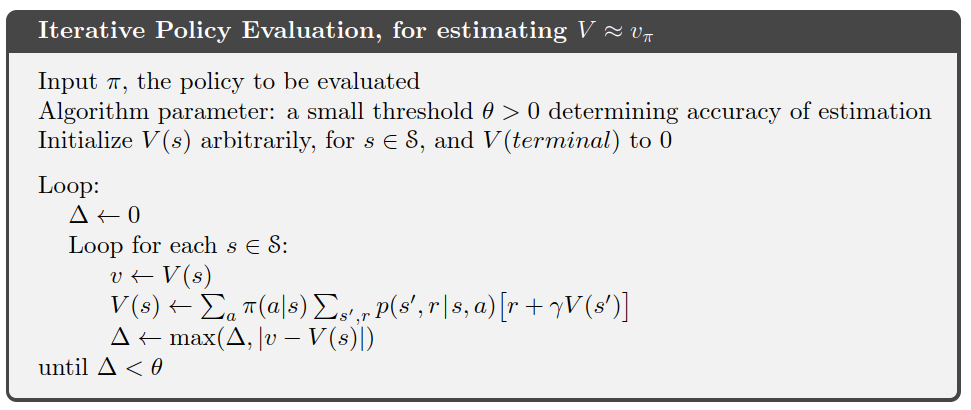

### Implementation
With all of that out of the way, let's finally implement Policy Evaluation.

In [4]:
# Initialization
ACTION_PROB = 0.25 # action probabilty (equiprobable)
DISCOUNT = 1
THRESHOLD = 1e-3

state_values = np.zeros(len(env.observation_space))
episode = 0

# Policy Evaluation
while True:
    old_state_values = state_values.copy() # used to compute delta
    # compute State Value for all states
    for state in env.observation_space: 
        new_value = 0
        for action in env.action_space:
            trans_prob, next_state, reward, done = env.P[state][action]
            # Value Function
            new_value += ACTION_PROB  * trans_prob * (reward + DISCOUNT * old_state_values[next_state])
        # assign new value
        state_values[state] = new_value
    # convergence threshold attained
    max_delta = abs(old_state_values - state_values).max()
    if max_delta < THRESHOLD:
        break
    # Increment episodes for logging
    episode += 1

[]

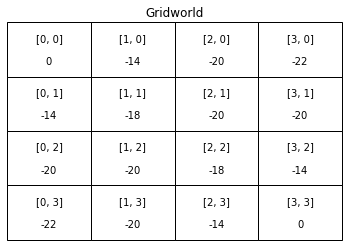

In [5]:
# Draw grid
fig, ax = plt.subplots()
ax.set_title("Gridworld")
ax.set_axis_off()
tb = Table(ax, bbox=[0, 0, 1, 1])

width, height = 1.0 / 4, 1.0 / 4

# Add cells
for idx in range(4**2):
    coord = env.map_1d_to_2d(idx)
    tb.add_cell(coord[1], coord[0],
                width,
                height,
                text="{coordinate}\n\n{value}".format(coordinate=coord, value=round(state_values[idx])),
                loc='center',
                facecolor='white')
ax.add_table(tb)
plt.plot()

Running our code, we see that the Value Function has converged and as shown in the table above. Next we'll